In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Dong, Yunbo (1420631)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

The first layer used relu because relu could generate good 'sparsity'. According to the results, softsign and tanh were both very good choices, but softsign tended to stabilize. From the experimental results, we could also tried selu, but since it could be considered as self-normalization, next questions seemed meaningless for this. Layer 3 used softmax to output with 10 neurons because there were 10 classes.  (length: 414)



Max val score: 77.74%


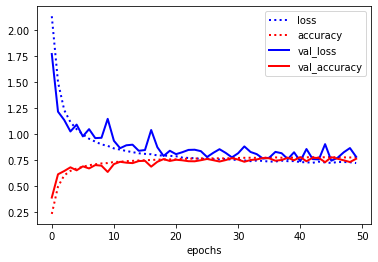

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_92 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_93 (Dense)             (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(128, activation='softsign'))
  # model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



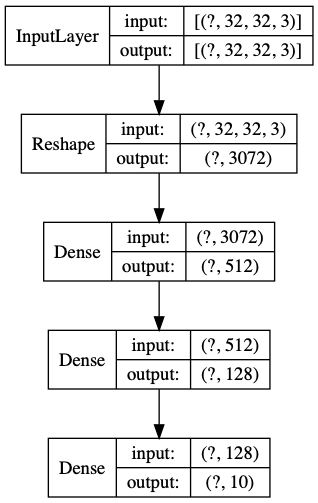

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The effect was improved because the original data was preprocessed, namely, the original picture was changed to grayscale, and the data sparsity was increased, so the performance naturally improved. I used to normalize as well, but because of the requirement for the rerun, it is expected that there will not be a very large improvement on the original model, because relu itself in the input layer has no special requirement of normalization.  (length: 445)



Max val score: 78.67%


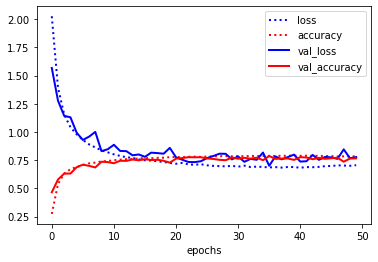

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_41 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_113 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_114 (Dense)            (None, 10)                1290      
Total params: 591,754
Trainable params: 591,754
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(512, activation='relu'))
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, cent

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

In theory, whether using selu, tanh or softsign for activation functions, generalization ability of the models themselves are not bad, they were not large networks, so sacrificing accuracy to improve generalization ability was not appropriate. Practically,  the effect of most regularization is very poor. The only implementation on the output layer, for a very little L2 regularization,  had a small effect.  (length: 410)



Max val score: 81.90%


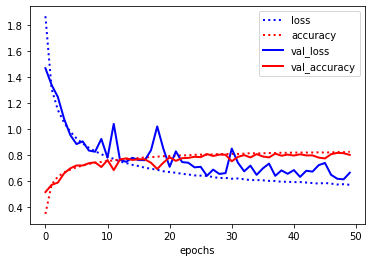

def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(512, activation='relu'))
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, 
                                  scale=True, beta_initializer='zeros', gamma_initializer='ones', 
                                  moving_mean_initializer='zeros', moving_variance_initializer='ones')
  model.add(layers.Dense(128, activation='softsign'))
  model.add(layers.Dense(10, activity_regularizer=keras.regularizers.l1(0.01), activation='softmax'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Because the original matrix was 2-dimensional (after rgb2gray), choosing Conv2D was the best in efficiency and performance. Padding =same was due to the case-insensitive character. After that, Max pooling operation for spatial data, (2, 2) would halve the input in both spatial dimension. Then apply Dropout to the input because the Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. Finally, the dense layer was changed to four layers, and the number of epochs was increased to 100, hoping to produce better results through more epochs and more dense layers. The Dense layers setup basically follows the first question, but adds a layer that used softsign and contains 128 nodes.  (length: 774)



Max val score: 92.40%


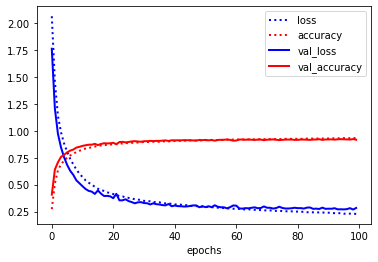

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)        

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=rgb2gray(X_train).shape[1:]))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, 
                                  scale=True, beta_initializer='zeros', gamma_initializer='ones', 
                                  moving_mean_initializer='zeros', moving_variance_initializer='ones')
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='tanh'))
    model.ad

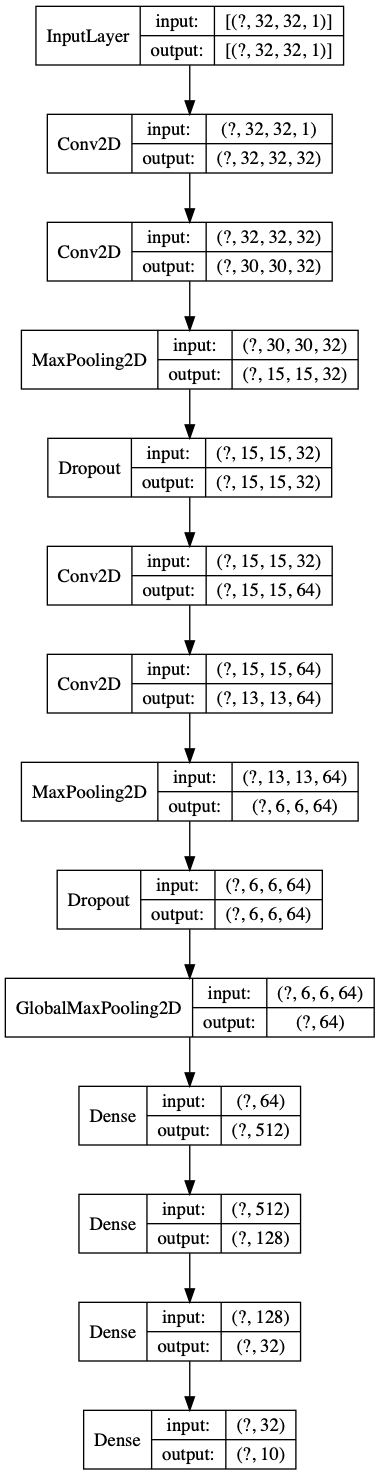

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Overall accuracy declined. Shift was the better transformation that could keep accuracy equal to before. And the odd thing I don't understand was that val_acc was even steadily higher than acc after making the transformation.  (length: 227)



Max val score: 91.50%


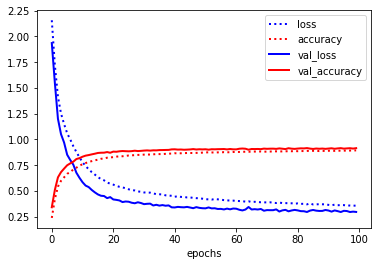


# datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, width_shift_range=0.1, 
#                                                        height_shift_range=0.1, horizontal_flip=True, 
#                                                        vertical_flip=True, fill_mode='nearest')


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

These labels are easy to be confused with: (2, 4),(3, 0),(6, 0),(6, 1), the first is the label, and the second is the prediction. They all had the ratios of no less than 0.03  (length: 176)

Test score: 0.89%
Confusion matrix, without normalization


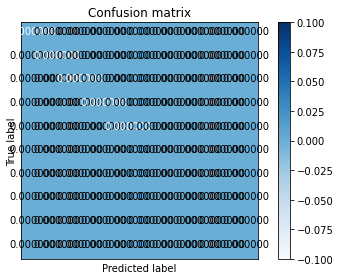

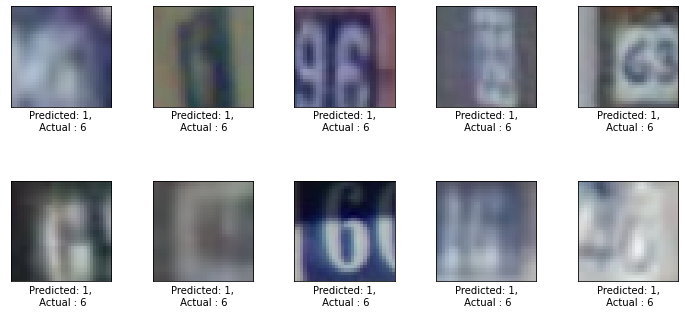

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

It is clear that the input layer did recognize the characteristics of each number. But the deeper net became, the worse it performed.  (length: 135)



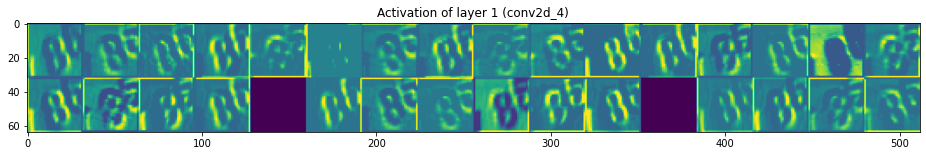

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

def plot_3_3():
  model_2_2 = load_model_from_file(base_dir, "model_2_2")
  img_tensor = X_test_pre[0]
  x = np.expand_dims(img_tensor, axis=0)
  eight_dig_output = model_2_2.output[:, 7]
  last_conv_layer = model_2_2.get_layer('conv2d_5')
  grads = keras.backend.gradients(eight_dig_output, last_conv_layer.output)[0]
  pooled_grads = keras.backend.mean(grads, axis=(0, 1, 2))
  iterate = keras.backend.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(32):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)

  heatmap = cv2.resize(heatmap, (32, 32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.00001 + X_test[0]
  plt.rcParams['figure.dpi'] = 120
  f, ax1 = plt.

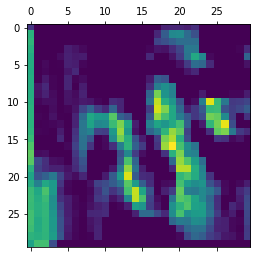

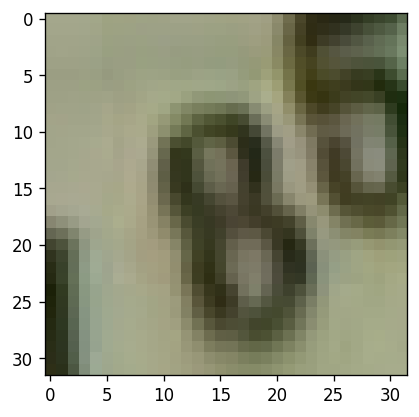

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

That worked better because, after freezing the convolutional base, the Global Average Pooling(GAP) Layers replaced the Fully Connected(FC) Layer. GAP made the model more robust because the transformation was more natural and reduced the spatial parameters. The observed performance is pretty good.  (length: 299)



Max val score: 95.61%


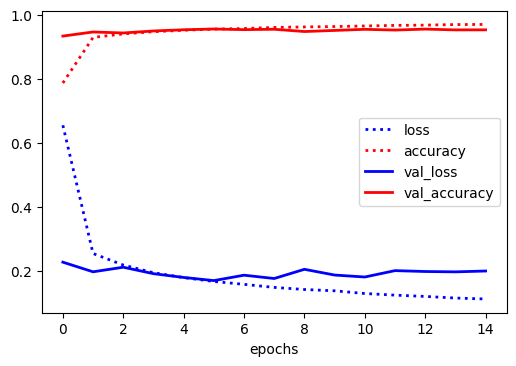

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________
None


def build_model_4_1():
    model = models.Sequential()
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    model.add(vgg)
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    i = 1
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model



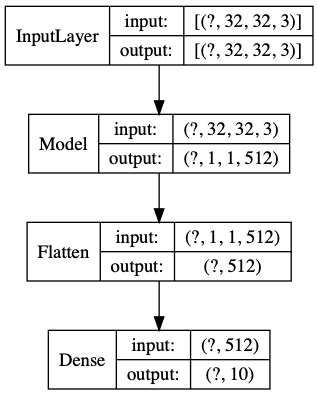

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

This is pretty good, but not as good as solution of question 4-1 or 2-2. And it is a little overfitting. But this method is very efficient and lightweight.  (length: 157)

Pipeline(steps=[('imputer', SimpleImputer()), ('reg', LinearRegression())])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model = load_model_from_file(base_dir, "model_4_1")
    f_extra_model = model.get_layer("vgg16")
    f_train = f_extra_model.predict(X_train_all)
    f_test = f_extra_model.predict(X_test)
    f_train = f_train.reshape(f_train.shape[0], 512)
    f_test = f_test.reshape(f_test.shape[0], 512)
    store_embedding(f_train, "train_embeddings")
    store_embedding(f_test, "test_embeddings")

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  pipeline = generate_pipeline()
  train_acc, test_acc = evaluate_pipeline(pipeline=pipeline, X_train=X_train, y_train

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 140.37 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
